In [1]:
# Google Drive Connection
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/fake-or-not/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
dataset		     dataset_correct_ManTraNet.csv
dataset_correct.csv  output_vggnet16_cnn.csv


In [2]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Image processing and ELA conversion
import PIL
from PIL import Image
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# General ML models
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
# from pandas_ml import ConfusionMatrix

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.engine.input_layer import Input
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2
from skimage import io
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
def get_imlist(path):
    '''
    Input:
        path: path to the folder containing all the images to work with
    Output:
        list of all image file names inside the path
    '''
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

path = '/content/drive/My Drive/fake-or-not/data/dataset/dataset/'
image_names = get_imlist(path)
image_names.sort()

OSError: ignored

In [0]:
image_names[:7]

In [0]:
# create dataframe with image filenames and labels
dataset = pd.DataFrame(image_names, columns = ['file_name'])

# assign class according to file name
dataset['fake'] = 0

dataset['fake'] = np.where(dataset['file_name'].str.endswith('_fake.jpg'), 1, dataset['fake'])

# check the balance of the dataset
pd.crosstab(index = dataset['fake'], columns = 'Freq')/len(image_names)

NameError: ignored

In [0]:
def image2array(filename, size=(128, 128)):
    '''
    Convert an image to numpy array.
    Input:
        filename: name of input image file.
        size: size of output image.
    Outpiut:
        image: numpy array
    '''
    exceptions_occurred = 0
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(size, PIL.Image.NEAREST)
    except Image.UnidentifiedImageError or OSError:
        exceptions_occurred += 1
        pass

    return np.array(image)

In [0]:
# create X and Y for training deep neural network
X = []  # images
Y = []  # labels

# height, width and number of channels in each image
width = 128
height = 128
n_channels = 3
new_index = []
filname_loaded = []
for index, row in dataset.iterrows():
    try:
        X.append(image2array(row[0], (width, height))/ 255.0)
        Y.append(row[1])
        filename_loaded.append(row[0])
        new_index.append(index)
    except:
        print("Image {} dropped. Could not be processed.".format(re.sub('/content/drive/My Drive/fake-or-not/data/dataset/', '', dataset['file_name'][index])))
        pass

    if index % 1000 == 0:

        print(index, "images parsed")

# reshpe X
X = np.array(X)
X = X.reshape(-1, width, height, n_channels)

# one-hot encode Y
Y = tf.keras.utils.to_categorical(Y, 2)

# discard images from the original dataset that were unable to load
dataset_correct = dataset[dataset.index.isin(new_index)]
dataset_correct = dataset_correct.reset_index(drop=True)

# print dimensions
print(X.shape)
print(Y.shape)

In [0]:
# divide data into train, validation and test sets
test_size = int(X.shape[0]*0.15)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1, shuffle=False)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=test_size, random_state=1, shuffle=False)

NameError: ignored

In [0]:
print(X_train.shape)
print(Y_train.shape)

print(X_validation.shape)
print(Y_validation.shape)

print (X_test.shape)
print(Y_test.shape)


(14836, 128, 128, 3)
(14836, 2)
(3178, 128, 128, 3)
(3178, 2)
(3178, 128, 128, 3)
(3178, 2)


In [0]:
'''
VGG Net
'''

# load and compile model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump
from keras.layers import GlobalAveragePooling2D
from keras import regularizers

# release GPU memory
tf.keras.backend.clear_session()

# model properties
model_type = 'VGG16'
model_save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)
filepath = os.path.join(model_save_dir, model_name)

# create callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]


# load model
input_shape = X.shape[1:]
n_classes = Y.shape[1]

width = 128
height = 128
vgg_model = VGG16(include_top=False, input_shape=(width, height, 3))

for layer in vgg_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = True

model = Sequential()

model.add(vgg_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_______________________________________________________

In [0]:
# fit model
n_samples = X_train.shape[0]
batch_size = 64
epochs = 125
history = model.fit(X_train[:n_samples], Y_train[:n_samples],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_validation, Y_validation),
              shuffle=True,
              verbose=1,
              callbacks=callbacks)

Train on 14836 samples, validate on 3178 samples
Epoch 1/125
14836/14836 [==============================] - 51s 3ms/step - loss: 1.0255 - accuracy: 0.5075 - val_loss: 1.2390 - val_accuracy: 0.5009
Epoch 2/125
   64/14836 [..............................] - ETA: 36s - loss: 0.9403 - accuracy: 0.4531

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


14836/14836 [==============================] - 40s 3ms/step - loss: 0.9057 - accuracy: 0.5154 - val_loss: 1.6204 - val_accuracy: 0.5138
Epoch 3/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.8532 - accuracy: 0.5307 - val_loss: 2.4666 - val_accuracy: 0.5000
Epoch 4/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.8204 - accuracy: 0.5374 - val_loss: 0.9345 - val_accuracy: 0.5057
Epoch 5/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.7929 - accuracy: 0.5497 - val_loss: 1.1505 - val_accuracy: 0.5016
Epoch 6/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.7730 - accuracy: 0.5599 - val_loss: 1.0055 - val_accuracy: 0.5000
Epoch 7/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.7590 - accuracy: 0.5589 - val_loss: 0.9263 - val_accuracy: 0.4924
Epoch 8/125
14836/14836 [==============================] - 40s 3ms/step - loss: 0.7525 - accuracy: 0.5450 - val_loss: 0.8254

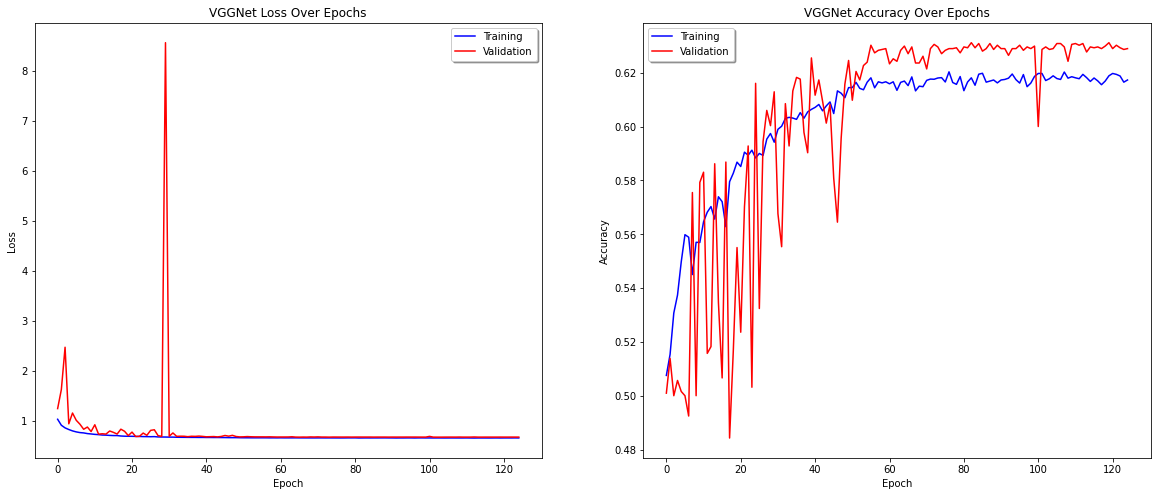

In [0]:
# plot loss and accuracy curve
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(history.history['loss'], color='b', label="Training")
ax[0].plot(history.history['val_loss'], color='r', label="Validation",axes =ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("VGGNet Loss Over Epochs")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("VGGNet Accuracy Over Epochs")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
'''
ResNet
'''

from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras import regularizers

model_type = 'ResNet50'
model_save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)
filepath = os.path.join(model_save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

width = 128
height = 128

# load model
model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(width, height, 3))

for layer in resnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers[20:]:
    layer.trainable = True

model.add(resnet_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 23,850,754
Trainable params: 23,695,682
Non-trainable params: 155,072
_________________________________________________________________


In [0]:
# fit model
n_samples = X_train.shape[0]
batch_size = 32
epochs = 25
history = model.fit(X_train[:n_samples], Y_train[:n_samples],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_validation, Y_validation),
              shuffle=True,
              verbose=1,
              callbacks=callbacks)

Train on 14836 samples, validate on 3178 samples
Epoch 1/25
14836/14836 [==============================] - 84s 6ms/step - loss: 1.3489 - accuracy: 0.5333 - val_loss: 0.7583 - val_accuracy: 0.5000
Epoch 2/25
   32/14836 [..............................] - ETA: 1:03 - loss: 0.8025 - accuracy: 0.3438

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


14836/14836 [==============================] - 69s 5ms/step - loss: 0.7259 - accuracy: 0.5483 - val_loss: 0.7207 - val_accuracy: 0.5000
Epoch 3/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.7153 - accuracy: 0.5551 - val_loss: 0.7301 - val_accuracy: 0.5000
Epoch 4/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.7138 - accuracy: 0.5610 - val_loss: 82.9460 - val_accuracy: 0.5000
Epoch 5/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.7061 - accuracy: 0.5609 - val_loss: 0.7592 - val_accuracy: 0.5000
Epoch 6/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.7277 - accuracy: 0.5621 - val_loss: 0.7224 - val_accuracy: 0.5000
Epoch 7/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.7155 - accuracy: 0.5522 - val_loss: 0.7119 - val_accuracy: 0.5000
Epoch 8/25
14836/14836 [==============================] - 69s 5ms/step - loss: 0.6976 - accuracy: 0.5600 - val_loss: 0.7145 - va

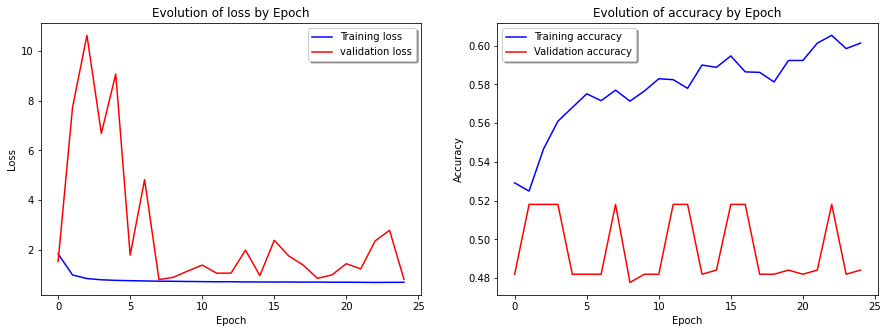

In [0]:
# plot loss and accuracy curve
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history['loss'], color='b', label="Training")
ax[0].plot(history.history['val_loss'], color='r', label="Validation",axes =ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("VGGNet Loss Over Epochs")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("VGGNet Accuracy Over Epochs")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    """
    Input:
        y_true    : array of true binary labels. Eg: [0, 1, 0, 0, 1].
        y_pred    : array of predicted probabilities. Eg: [0.05, 0.55, 0.2, 0.8, 0.95].
        normalize : whether to show counts of proportion in a cell
    
    Output:
        confusion matrix
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    #plt.colorbar()
    classes = np.unique(y_true)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if(normalize):
        precision=4
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], precision)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    pass

In [0]:
# train on full training set
X = np.concatenate((X_train, X_validation), axis=0)
Y = np.concatenate((Y_train, Y_validation), axis=0)

# load model
model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(width, height, 3))

for layer in resnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers[20:]:
    layer.trainable = True

model.add(resnet_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

# fit model
n_samples = X_train.shape[0]
batch_size = 32
epochs = 25
history = model.fit(X_train[:n_samples], Y_train[:n_samples],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_validation, Y_validation),
              shuffle=True,
              verbose=1,
              callbacks=callbacks)

In [0]:
# make predictions on test set
y_pred = model.predict(X_test)

In [0]:
file_names = pd.read_csv("/content/drive/My Drive/fake-or-not/data/dataset_correct.csv")
path = file_names[['file_name']]
path = path[-3178:]
path.columns = ['path']

(3178, 1)

In [0]:
label_0 = list(y_pred[:,0])
label_1 = list(y_pred[:,1])

df_output = pd.DataFrame({'path': path.values.ravel().tolist(), 'label_0': label_0, 'label_1': label_1})
df_output.to_csv("/content/drive/My Drive/fake-or-not/Result/output_vggnet16.csv")

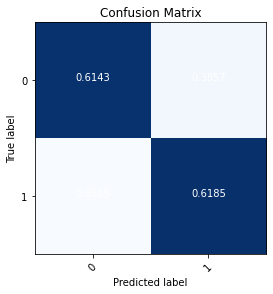

In [0]:
y_pred_class = np.round(y_pred[:, 1])
y_pred_class = [int(p) for p in y_pred_class]
y_test = np.argmax(Y_test, axis=1)
y_test = [int(p) for p in y_test]
plot_confusion_matrix(y_test, y_pred_class, normalize=True)